In [1]:
%pylab inline
import condor, spimage, h5py
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


In [140]:
index = 6
filename = '/Users/benedikt/data/LCLS/amol3416/sizing/tbsv_singles_with_data.h5'
with h5py.File(filename, 'r') as f:
    image = f['data'][index]
    mask = ~f['mask'][index].astype(np.bool)
    intensity = f['intensity'][index]
    diameter = f['diameter_nm'][index]
    runnr = f['runnr'][index]
    timestamp = f['timestamp'][index]

In [141]:
# Mask and background-removal
image[image < 0.5] = 0.

In [142]:
# Find the center 
x,y = spimage.find_center(image, mask, method='blurred', x0=0, y0=0, 
                          dmax=40, threshold=0.5, blur_radius=4)
    
# Crop around the center to 1024x1024
centery = int(image.shape[0]//2+y + 50)
centerx = int(image.shape[1]//2+x + 50)
data_padded = np.pad(image, 50, 'constant')
data_cropped = data_padded[centery-512:centery+512, centerx-512:centerx+512]
mask_padded  = np.pad(mask, 50, 'constant')
mask_cropped = mask_padded[centery-512:centery+512, centerx-512:centerx+512]

In [143]:
# Downsampling
data_ds, mask_ds = spimage.binImage(data_cropped, 8, msk=mask_cropped, output_binned_mask=True)
    
# Photon counting
data_cnt = np.round(data_ds)
mask_cnt = mask_ds == 64

In [144]:
# Parameters
pixelsize = 75e-6 #[m]
distance = 259e-3 #[m]
wl = 1.54e-9 #[m]
dx = wl * distance / (1024. * pixelsize) #[m/px]
initial_support = np.round(30./(dx*1e9))
iterations_raar = 1000
iterations_er = 1000
iterations_total = iterations_raar + iterations_er
beta = 0.9
    
# Phasing
R = spimage.Reconstructor()
R.set_intensities(data_cnt)
R.set_mask(mask_cnt)
R.set_number_of_iterations(iterations_total)
R.set_number_of_outputs_images(20)
R.set_number_of_outputs_scores(1000)
R.set_initial_support(radius=initial_support/2)
support_area = pi * (initial_support/2)**2 / (data_cnt.shape[0]**2)
R.append_support_algorithm("static", number_of_iterations=iterations_total, center_image=True)
R.append_phasing_algorithm("raar",beta_init=beta, beta_final=beta, number_of_iterations=iterations_raar, 
                               constraints=['enforce_real', 'enforce_positivity'])
R.append_phasing_algorithm("er",  number_of_iterations=iterations_er,
                               constraints=['enforce_real', 'enforce_positivity'])
output = R.reconstruct_loop(100)

In [145]:
res = spimage.prtf(output['real_space_final'], output['support_final'], translate=True, enantio=True)

In [146]:
with h5py.File('/Users/benedikt/data/LCLS/amol3416/phasing/tbsv_phased_single_%d.h5' %index, 'w') as f:
    f['data'] = data_cropped
    f['mask'] = mask_cropped
    f['intensity'] = intensity
    f['diameter'] = diameter
    f['runnr'] = runnr
    f['timestamp'] = timestamp
    f['super_image'] = res['super_image']
    f['prtf'] = res['prtf']

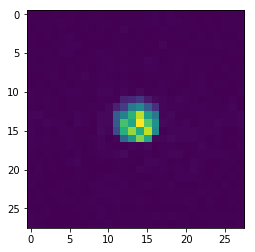

In [118]:
c = 50
img = output['real_space_final'][0]
plt.figure()
plt.imshow(np.abs(img)[c:-c,c:-c])
plt.show()

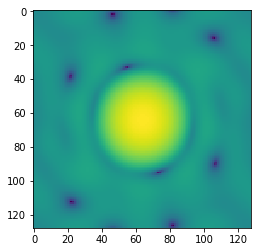

In [86]:
img = output['fourier_space_final'][5]
plt.figure()
plt.imshow(np.abs(img), norm=LogNorm())
plt.show()

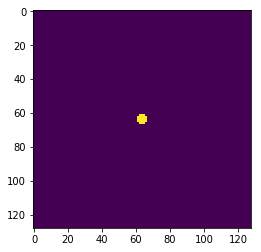

In [107]:
img = output['support_final'][-1]
plt.figure()
plt.imshow(img)
plt.show()

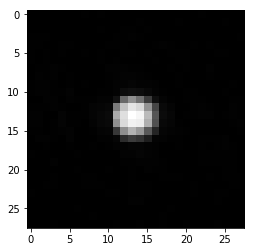

In [139]:
img = res['super_image']
plt.figure()
plt.imshow(np.abs(img)[c:-c,c:-c], cmap='gray')
plt.show()

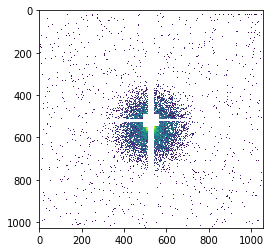

In [131]:
plt.figure()
plt.imshow(image, norm=LogNorm())
plt.show()